In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
from src.utils.data import read_fasta
from src.utils.evaluation import metrics_per_label_df
from torchmetrics.classification import AveragePrecision
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from src.utils.losses import FocalLoss
from src.utils.evaluation import EvalMetrics
import re
import obonet
from src.utils.data import get_ec_class_descriptions,ec_number_to_code,read_json
ec_class_descriptions = get_ec_class_descriptions('../data/annotations/enzclass.txt')

graph = obonet.read_obo('../data/annotations/go_may_2024.obo')
parenthood_2019 = read_json('../data/vocabularies/parenthood_2019.json')

In [2]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')
zero_shot = read_fasta('../data/zero_shot/GO_swissprot_may_2024.fasta')
zero_shot_ln = read_fasta('../data/zero_shot/GO_swissprot_leaf_nodes_may_2024.fasta')

In [3]:
for dataset in ['train','val','test','zero_shot','zero_shot_ln']:
    exec(f'{dataset} = [(seq,id," ".join(labels),"{dataset}") for seq,id,labels in {dataset}]')

df = train + val + test + zero_shot + zero_shot_ln

In [4]:
df = pd.DataFrame(df,columns=['sequence','id','labels','split'])
df_zero_shot = pd.DataFrame(zero_shot,columns=['id','sequence','labels','split'])

In [5]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 589117


In [6]:
df['num_pos'] = df['labels'].str.split(' ').str.len()
df['num_pos'].describe()

count    589117.000000
mean         42.537068
std          39.032551
min           1.000000
25%          17.000000
50%          39.000000
75%          56.000000
max        1008.000000
Name: num_pos, dtype: float64

In [7]:
df['labels'].str.split(' ').apply(len).describe()

count    589117.000000
mean         42.537068
std          39.032551
min           1.000000
25%          17.000000
50%          39.000000
75%          56.000000
max        1008.000000
Name: labels, dtype: float64

In [8]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df[df['split']=='train'].iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [9]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 31365


In [10]:
print('GO Terms distribution')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

GO Terms distribution


count     31365.000000
mean        635.987821
std        7372.964658
min           1.000000
25%           4.000000
50%          14.000000
75%          70.000000
max      369909.000000
dtype: float64

In [11]:
go_term_distribution[go_term_distribution>0]

GO:0003674    369909
GO:0008150    346677
GO:0005575    321980
GO:0009987    295442
GO:0044464    291432
               ...  
GO:1903890         1
GO:0102632         1
GO:0010059         1
GO:0072616         1
GO:0030787         1
Length: 31365, dtype: int64

In [12]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    589117.000000
mean        370.042233
std         345.004835
min           2.000000
25%         178.000000
50%         303.000000
75%         458.000000
max       35213.000000
Name: sequence, dtype: float64

In [13]:
df['sequence'].apply(len).quantile(.99)

1534.0

In [14]:
len(set([j for i in df.query('split=="test"')['labels'] for j in i.split(' ')]))

22026

# Zero Shot Performance

In [133]:
from torcheval.metrics import MultilabelAUPRC, BinaryAUPRC, BinaryBinnedAUPRC, MultilabelBinnedAUPRC

def get_metrics(logits_df,labels_df,device,threshold):

    logits = torch.tensor(logits_df.values,device=device)
    labels = torch.tensor(labels_df.values,device=device)
    probabilities = torch.sigmoid(logits)

    eval_metrics = EvalMetrics(device)
    selected_eval_metrics=eval_metrics.get_metric_collection_with_regex(pattern="f1_m.*",
                                                                    threshold=threshold,
                                                            num_labels=labels.shape[-1])
    mAP_micro = BinaryAUPRC(device=device)
    mAP_macro = MultilabelAUPRC(device=device,
                                num_labels=labels.shape[-1])
    
    selected_eval_metrics(probabilities, labels)
    mAP_micro.update(probabilities.flatten(), labels.flatten())
    mAP_macro.update(probabilities, labels)

    metrics = {'mAP Macro':mAP_macro.compute(),'mAP Micro':mAP_micro.compute(),**selected_eval_metrics.compute()}
    return {k:v.item() for k,v in metrics.items()}

def get_namespace_from_parenthood(go_term,parenthood):
    go_term_to_namespace = {'GO:0008150':'biological_process',
                            'GO:0003674':'molecular_function',
                            'GO:0005575':'celular_component'}
    for parent in parenthood[go_term]:
        if parent in go_term_to_namespace:
            namespace = go_term_to_namespace[parent]
            break
    return namespace
#TODO: Remove if else part
def filter_by_go_namespace(namespace:str,df:pd.DataFrame,graph = None, parenthood= None):

    assert (graph is not None) ^ (parenthood is not None)

    if graph is not None:
        col_mask = [(graph.nodes[go_term]["namespace"] if  go_term in graph.nodes else 'missing') for go_term in df.columns]
    if parenthood is not None:
        col_mask = [get_namespace_from_parenthood(go_term,parenthood) for go_term in df.columns]
    
    assert namespace in ['All','biological_process', 'cellular_component', 'molecular_function']
    if namespace=='All':
        return df
    filtered_df = df.iloc[:,[namespace==i for i in col_mask]]
    return filtered_df

def filter_by_ec_level_1(namespace:str,df:pd.DataFrame,ec_class_descriptions:dict):
    ec_number_to_ec_level_1 = lambda ec_number: (ec_number_to_code(ec_number)[0],0,0)
    col_mask = [ec_class_descriptions[ec_number_to_ec_level_1(ec_number)]['label'] for ec_number in df.columns]
    if namespace=='All':
        return df
    filtered_df = df.iloc[:,[i==namespace for i in col_mask]]
    return filtered_df

def metrics_by_go_namespace(df_logits,df_labels,graph,device,threshold):
    results = {}
    for namespace in ['All','biological_process', 'cellular_component', 'molecular_function']:
        filtered_df_logits = filter_by_go_namespace(namespace,df_logits,graph)
        filtered_df_labels = filter_by_go_namespace(namespace,df_labels,graph)
        results[namespace] = get_metrics(filtered_df_logits,filtered_df_labels,device=device,threshold=threshold)
    return results

def metrics_by_ec_level_1(df_logits,df_labels,ec_class_descriptions,device,threshold):
    results = {}
    ec_level_1s = [ec_class_descriptions[(i,0,0)]['label'] for i in range(1,8)]
    for ec_level_1 in ['All'] + ec_level_1s:
        filtered_df_logits = filter_by_ec_level_1(namespace=ec_level_1,df=df_logits,ec_class_descriptions=ec_class_descriptions)
        filtered_df_labels = filter_by_ec_level_1(namespace=ec_level_1,df=df_labels,ec_class_descriptions=ec_class_descriptions)
        results[ec_level_1] = get_metrics(filtered_df_logits,filtered_df_labels,device=device,threshold=threshold)
    return results

def save_fig(name):
    plt.savefig(f'{name}.png', format='png', dpi=1200,bbox_inches='tight')


def plot_axes_add_letter_index(axes,loc = (0.1, 0.9)):
  letters = 'abcdefghijklmnopqrstuvwxyz'
  for i, ax in enumerate(axes.flat):
      ax.text(*loc, f'{letters[i]})', transform=ax.transAxes, fontsize=12, fontweight='bold')

def plot_category_performance(metrics_df:pd.DataFrame,
                              test_name:str,
                              metric:str,
                              category_name:str,
                              ylim:tuple=(0,0.5),
                              rotate_x_ticks:bool = False,
                              pltshow = True,
                              savefig = True,
                              name:str = None,
                              ax = None):
    
    plot_df = metrics_df.query("metric == @metric and test_name == @test_name").melt(ignore_index=False,
                                                                        var_name=[category_name],
                                                                        value_name=metric)\
                                                                        .reset_index()
    

    sns.barplot(data = plot_df,
                x=category_name,
                y=metric,
                alpha=0.8,
                hue='model',
                ax=ax)
    sns.despine()
    plt.ylim(*ylim)
    plt.title(f'{metric} - {test_name}')
    if rotate_x_ticks:
        plt.xticks(rotation=30)
    if savefig:
        assert name is not None, "Must add a name if saving the figure"
        save_fig(name)
    if pltshow:
        plt.show()

In [45]:
model_checkpoint = 'normal_test_label_aug_v4'
zero_shot_labels = {'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':('Leaf Nodes',pd.read_parquet(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_{model_checkpoint}.parquet')),
                    'TEST_DATA_PATH_ZERO_SHOT':('Leaf Nodes + Inferred',pd.read_parquet(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_{model_checkpoint}.parquet')),
                    'TEST_EC_DATA_PATH_ZERO_SHOT':('EC Zero Shot',pd.read_parquet(f'../outputs/results/test_1_labels_TEST_EC_DATA_PATH_ZERO_SHOT_{model_checkpoint}.parquet'))
                    }

zero_shot_predictions = {'Ours':{'TEST_DATA_PATH_ZERO_SHOT':pd.read_parquet(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_{model_checkpoint}.parquet"),
                                 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':pd.read_parquet(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_{model_checkpoint}.parquet"),
                                  'TEST_EC_DATA_PATH_ZERO_SHOT':pd.read_parquet(f"../outputs/results/test_1_logits_TEST_EC_DATA_PATH_ZERO_SHOT_{model_checkpoint}.parquet")
                                 },
                          'baseline_e5':{'TEST_DATA_PATH_ZERO_SHOT':pd.read_parquet("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_E5_baseline.parquet"),
                                        'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':pd.read_parquet("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_E5_baseline.parquet"),
                                        'TEST_EC_DATA_PATH_ZERO_SHOT':pd.read_parquet("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_E5_baseline.parquet")
                                 },
                           'baseline_biogpt':{'TEST_DATA_PATH_ZERO_SHOT':pd.read_parquet("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_BioGPT_baseline.parquet"),
                                          'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':pd.read_parquet("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_BioGPT_baseline.parquet"),
                                          'TEST_EC_DATA_PATH_ZERO_SHOT':pd.read_parquet("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_BioGPT_baseline.parquet")
                     }
                        }

namespace2alias = {'molecular_function':'MF','biological_process':'BP','cellular_component':'CC','All':'All'}

In [125]:

test_sets = ['TEST_DATA_PATH_ZERO_SHOT', 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES']
model = 'Ours'
metrics = ['mAP Macro','mAP Micro']
category_name = 'Namespace'
threshold = 0.3
final_metrics_df = []
device = 'cuda'
for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        logits_df = zero_shot_predictions[model][test_set]
        metrics_df = metrics_by_go_namespace(df_logits=logits_df,
                            df_labels=labels_df,
                            graph=graph,
                            device=device,
                            threshold=threshold)

        metrics_df = pd.DataFrame(metrics_df)
        metrics_df['model'] = model
        metrics_df['test_name'] = test_name
        metrics_df.index.name = 'metric'
        metrics_df = metrics_df.set_index(['model','test_name'],append=True)

        final_metrics_df.append(metrics_df)
final_metrics_df  = pd.concat(final_metrics_df)
final_metrics_df.columns = final_metrics_df.columns.map(namespace2alias)



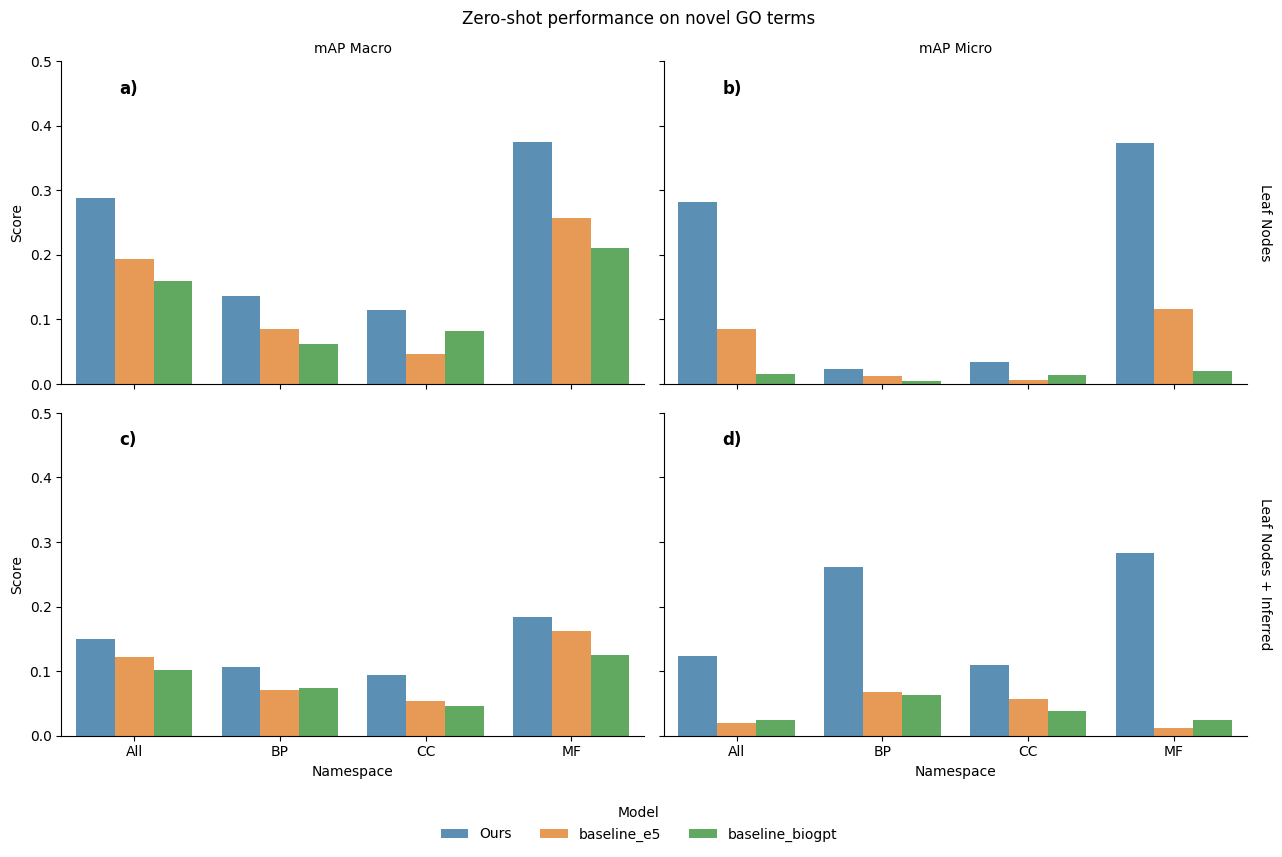

In [126]:

        
g = sns.FacetGrid(data = final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  row='test_name',
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=4,
                  aspect=1.1,
                  row_order=['Leaf Nodes','Leaf Nodes + Inferred'])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.figure.suptitle('Zero-shot performance on novel GO terms')
g.map_dataframe(sns.barplot,
                hue = 'model',
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.add_legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.tight_layout()
plot_axes_add_letter_index(g.axes)

# plt.ylim(*ylim)
# plt.title(f'{metric} - {test_name}')
save_fig(name = 'GO Zero Shot Perf')

### EC Predictions

In [112]:

test_sets = ['TEST_EC_DATA_PATH_ZERO_SHOT']
metrics = ['mAP Macro','mAP Micro']
final_metrics_df = []
threshold = 0.3
category_name = 'Top-level EC Class'
device = 'cuda'
for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        if test_set not in zero_shot_predictions[model]:
            continue
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        logits_df = zero_shot_predictions[model][test_set]
        metrics_df = metrics_by_ec_level_1(df_logits=logits_df,
                                        df_labels=labels_df,
                                        ec_class_descriptions=ec_class_descriptions,
                                        device=device,
                                        threshold=threshold)

        metrics_df = pd.DataFrame(metrics_df)
        metrics_df['model'] = model
        metrics_df['test_name'] = test_name
        metrics_df.index.name = 'metric'
        metrics_df = metrics_df.set_index(['model','test_name'],append=True)
        final_metrics_df.append(metrics_df)
final_metrics_df  = pd.concat(final_metrics_df)        

In [113]:
final_metrics_df

,,,All,Oxidoreductases,Transferases,Hydrolases,Lyases,Isomerases,Ligases,Translocases
metric,model,test_name,,,,,,,,
mAP Macro,Ours,EC Zero Shot,0.316324,0.342085,0.327945,0.240866,0.352817,0.312986,0.464293,0.089782
mAP Micro,Ours,EC Zero Shot,0.334424,0.412995,0.480064,0.222778,0.334032,0.242575,0.731301,0.017089
f1_macro,Ours,EC Zero Shot,0.225131,0.239668,0.233755,0.168591,0.247513,0.213251,0.377570,0.060625
f1_micro,Ours,EC Zero Shot,0.393092,0.440103,0.494963,0.291719,0.314876,0.273974,0.659123,0.063950
mAP Macro,baseline_e5,EC Zero Shot,0.204130,0.287348,0.174880,0.149119,0.224590,0.158948,0.279226,0.050675
mAP Micro,baseline_e5,EC Zero Shot,0.109722,0.182386,0.136585,0.060382,0.138583,0.114372,0.280060,0.003226
f1_macro,baseline_e5,EC Zero Shot,0.180249,0.256232,0.147169,0.128599,0.209800,0.149158,0.266883,0.023965
f1_micro,baseline_e5,EC Zero Shot,0.238988,0.363704,0.280438,0.141554,0.282716,0.255572,0.461272,0.001213
mAP Macro,baseline_biogpt,EC Zero Shot,0.095702,0.125832,0.084227,0.070026,0.070872,0.147614,0.138900,0.033287


/tmp/ipykernel_3434363/580301220.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
/tmp/ipykernel_3434363/580301220.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)


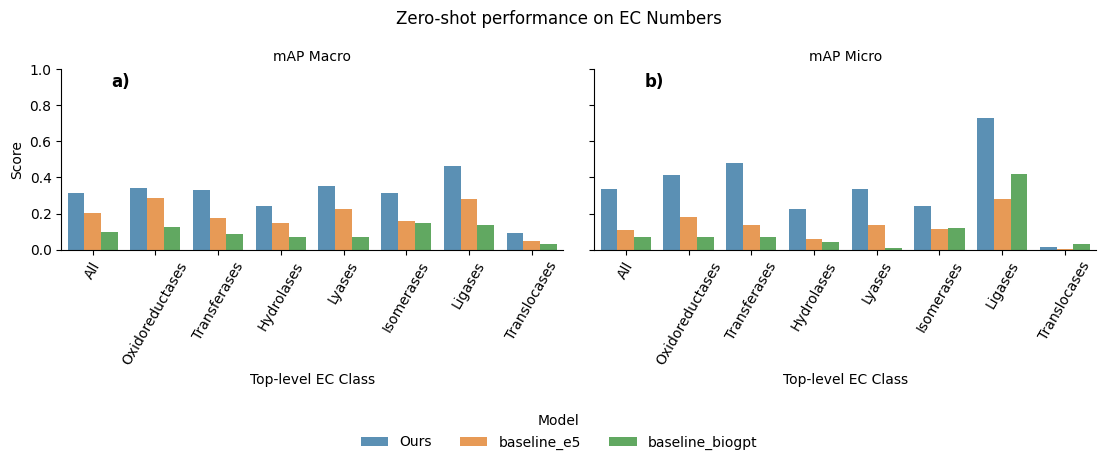

In [123]:

g = sns.FacetGrid(data = final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,1),
                  margin_titles=True,
                  height=4,
                  aspect=1.1,
                  legend_out=True)
g.figure.suptitle('Zero-shot performance on EC Numbers')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plot_axes_add_letter_index(g.axes)

g.add_legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.tight_layout()

# plt.ylim(*ylim)
# plt.title(f'{metric} - {test_name}')
save_fig(name = 'EC Zero Shot Perf')


# Explore Supervised Model Predictions

In [127]:
#Read Val Datas

models = {'Ours':{'logits_df':pd.read_parquet(f"../outputs/results/test_1_logits_TEST_DATA_PATH_{model_checkpoint}.parquet"),
                  'labels_df':pd.read_parquet(f"../outputs/results/test_1_labels_TEST_DATA_PATH_{model_checkpoint}.parquet")},
                  
          'Proteinfer':{'logits_df':pd.read_parquet("../outputs/results/test_logits_GO_TEST_DATA_PATH_proteinfer.parquet"),
                        'labels_df':pd.read_parquet("../outputs/results/test_labels_GO_TEST_DATA_PATH_proteinfer.parquet")}}

label_descriptions = pd.read_pickle('../data/annotations/go_annotations_may_2024.pkl')
label_descriptions['label'] = label_descriptions['label'].str.lower().str.rstrip()



In [128]:
non_zero_cols = list(models['Ours']['logits_df'].columns)

models['Proteinfer']['logits_df'] = models['Proteinfer']['logits_df'][non_zero_cols]
models['Proteinfer']['labels_df'] = models['Proteinfer']['labels_df'][non_zero_cols]


In [129]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated
def _get_metrics_by_label_and_freq(logits_df,
                                   labels_df,
                                   train_go_term_distribution,
                                   quantiles,
                                   threshold,device
                                   ):
    
    res = metrics_per_label_df(logits_df,labels_df,device=device,threshold=threshold)
    res["Frequency"] = res.index.map(train_go_term_distribution)
    
    #Bin frequencies
    freq_bins, freq_bin_edges = pd.qcut(train_go_term_distribution,q=quantiles,duplicates='drop',precision=0,retbins=True, labels=None)
    
    res['Frequency Bin']=res.index.map(freq_bins)    
    # res['Frequency Edges']=res.index.map(freq_bin_edges)    
    return res,freq_bins, freq_bin_edges



def get_metrics_by_label_and_freq(models,train_go_term_distribution,quantiles,threshold,device):
    res_dfs = []
    for model,data in models.items():
        print(model)
        logits_df = data['logits_df']
        labels_df = data['labels_df']

        res, freq_bins, freq_bin_edges = _get_metrics_by_label_and_freq(logits_df=logits_df,
                                             labels_df=labels_df,
                                             train_go_term_distribution=train_go_term_distribution,
                                             quantiles=quantiles,
                                             threshold=threshold,
                                             device=device)

        #Combine both dataframes
        res['model'] = model
        res_dfs.append(res)

    res_df=pd.concat(res_dfs,axis=0)

    # res_pivot = res_df.pivot(columns=['model'],values=[metric,'Frequency'])
    # res_pivot.columns = [i[0]+'_'+i[1] for i in res_pivot.columns]

    return res_df,freq_bins, freq_bin_edges


def plot_metric_by_label_freq(models,train_go_term_distribution,metric,quantiles,threshold,device):
    res_df,freq_bins, freq_bin_edges = get_metrics_by_label_and_freq(models=models,
                                                                     train_go_term_distribution = train_go_term_distribution,
                                                                     quantiles = quantiles,
                                                                     threshold = threshold,
                                                                     device = device)
    res_df.dropna(subset=[metric],inplace=True)
    freq_bins_pct = freq_bins.value_counts()*100/len(train_go_term_distribution)
    fig, ax = plt.subplots(figsize=(15,6))

    # Annotate bars with the percentage of observations
    for index, value in enumerate(freq_bins_pct.sort_index().values):
        ax.text(index, ax.get_ylim()[1]*0.01 + max(res_df[metric]) * 0.01, f"{value:.2f}%", ha='center')

    sns.barplot(data = res_df.reset_index(drop=True),
                x='Frequency Bin',
                y=metric,
                alpha=0.8,
                errorbar=('ci', 95),
                hue='model')
    ax.set(title=f'Individual label performance ({metric}) by label frequency quantiles',
        xlabel='Frequency of GO Function Annotation',
        ylabel=metric)
    sns.despine()
    plt.ylim(0,1)
    plt.show()



In [22]:
# import numpy as np
# #TODO: REMOVE THIS
# l = np.random.choice(list(go_term_distribution.index),size=615)
# for model,data in models.items():a
#     data['logits_df'].columns = l
#     data['labels_df'].columns= l

Ours


100%|██████████| 21898/21898 [00:33<00:00, 658.75it/s]


Proteinfer


100%|██████████| 21898/21898 [00:31<00:00, 690.98it/s]


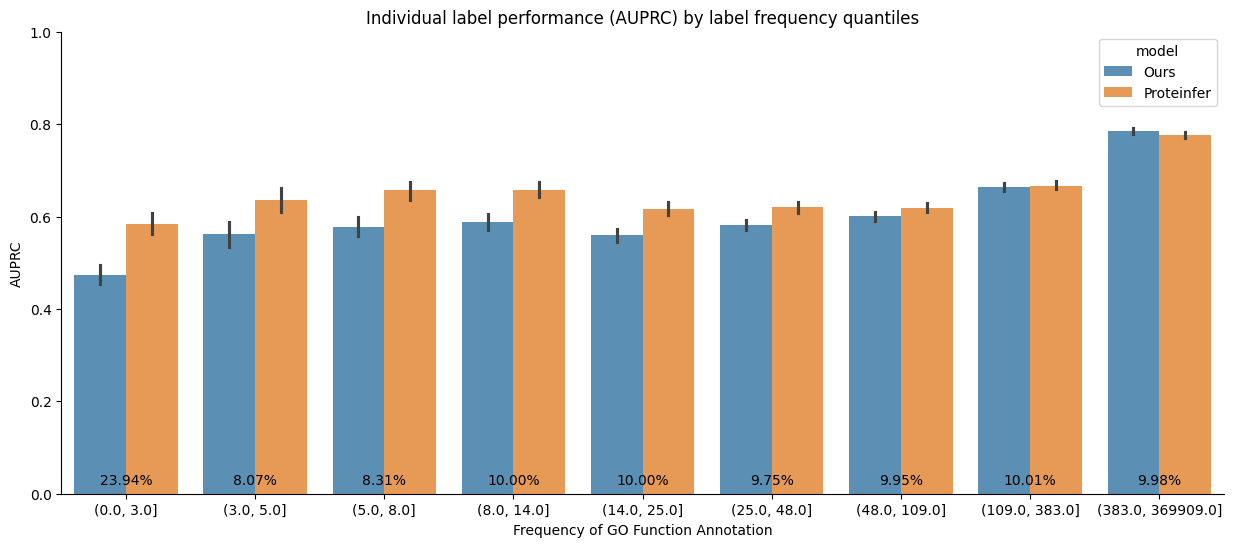

In [23]:
threshold = None
metric = 'AUPRC'
quantiles = 10 #May not find desired number and could be less.
device = 'cuda'
plot_metric_by_label_freq(models=models,
                          train_go_term_distribution = go_term_distribution,
                          metric = metric,
                          quantiles = quantiles,
                          threshold = threshold,
                          device = device)

In [130]:

test_set = 'TEST_DATA_PATH'
test_name = 'GO 2019 Supervised'
model = 'Ours'
graph = obonet.read_obo('../data/annotations/go_2019.obo')
threshold = 0.5
metrics_df = []
device = 'cpu'
for model in models.keys():
    labels_df = models[model]['labels_df']
    logits_df = models[model]['logits_df']
    metrics = metrics_by_go_namespace(logits_df,
                        labels_df,
                        graph,
                        device,
                        threshold)

    metrics = pd.DataFrame(metrics)
    metrics['model'] = model
    metrics['test_name'] = test_name
    metrics.index.name = 'metric'
    metrics = metrics.set_index(['model','test_name'],append=True)
    metrics_df.append(metrics)

metrics_df  = pd.concat(metrics_df)
metrics_df.columns = metrics_df.columns.map(namespace2alias)


In [131]:
metrics_df

,,,All,BP,CC,MF
metric,model,test_name,,,,
mAP Macro,Ours,GO 2019 Supervised,0.603867,0.570202,0.590251,0.710757
mAP Micro,Ours,GO 2019 Supervised,0.905727,0.881301,0.895789,0.966446
f1_macro,Ours,GO 2019 Supervised,0.552694,0.537515,0.524909,0.609947
f1_micro,Ours,GO 2019 Supervised,0.870409,0.847983,0.847051,0.932255
mAP Macro,Proteinfer,GO 2019 Supervised,0.641640,0.587830,0.634503,0.806247
mAP Micro,Proteinfer,GO 2019 Supervised,0.902662,0.873093,0.892940,0.964218
f1_macro,Proteinfer,GO 2019 Supervised,0.565426,0.517953,0.546077,0.715926
f1_micro,Proteinfer,GO 2019 Supervised,0.866260,0.839545,0.843709,0.936346


/tmp/ipykernel_3434363/2250095399.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels())
/tmp/ipykernel_3434363/2250095399.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels())


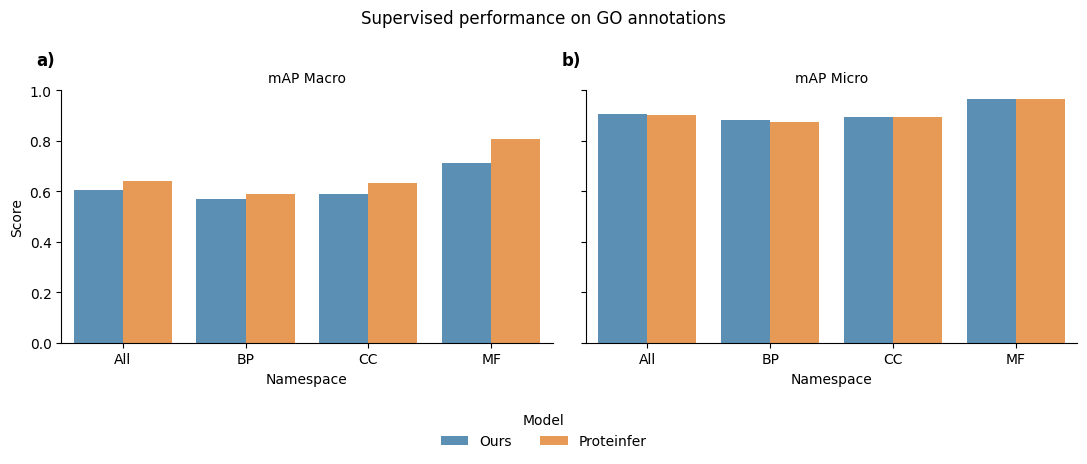

In [140]:
category_name = 'Namespace'
g = sns.FacetGrid(data = metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,1),
                  margin_titles=True,
                  height=4,
                  aspect=1.1,
                  legend_out=True)
g.figure.suptitle('Supervised performance on GO annotations')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels())
plot_axes_add_letter_index(g.axes,loc=(-0.05,1.1))

g.add_legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.tight_layout()

# plt.ylim(*ylim)
# plt.title(f'{metric} - {test_name}')
save_fig(name = 'GO Supervised Perf')


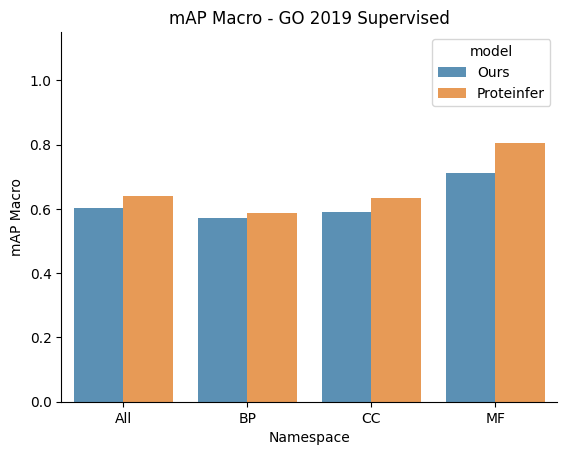

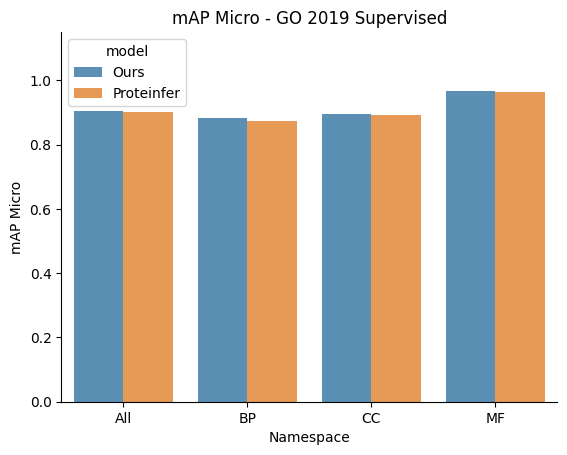

In [31]:
for metric in ['mAP Macro','mAP Micro']:
    plot_category_performance(metrics_df = metrics_df,
                            test_name=test_name,
                            metric = metric,
                            category_name = 'Namespace',
                            ylim=(0,1.15),
                            # figsize=(8,8)
                            )

In [29]:
cooc = models['Proteinfer']['labels_df'].values.T@models['Proteinfer']['labels_df'].values

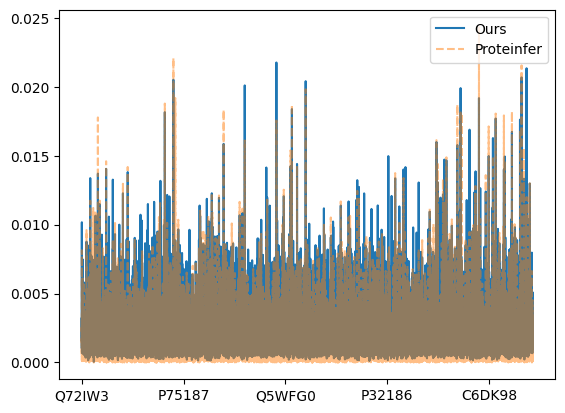

In [ ]:
val_probabilities.mean(axis=1).plot(label='Ours')
pinf_val_probabilities.mean(axis=1).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

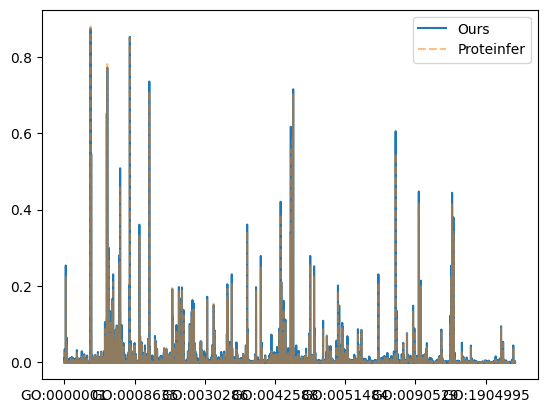

In [ ]:
val_probabilities.mean(axis=0).plot(label='Ours')
pinf_val_probabilities.mean(axis=0).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

In [ ]:
pd.DataFrame(val_probabilities.mean(axis=0)).corrwith(pd.DataFrame(pinf_val_probabilities.mean(axis=0)),axis=0)

0    0.995114
dtype: float64

In [ ]:
sequence_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=1)
label_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=0)

<Axes: >

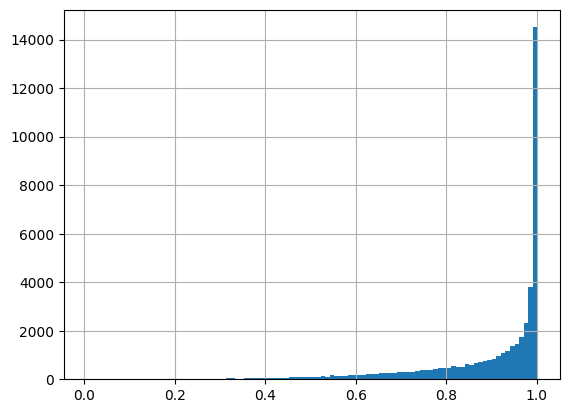

In [ ]:
sequence_dist_corr.hist(bins=100)

<Axes: >

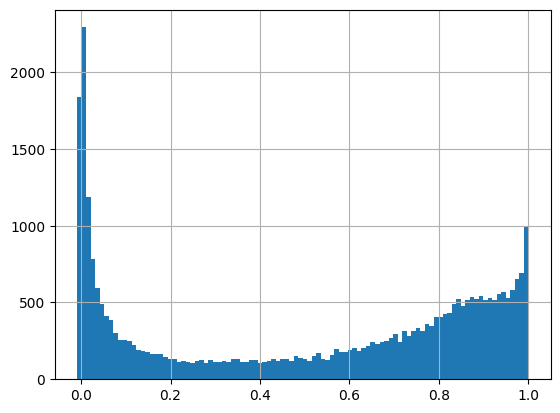

In [ ]:
label_dist_corr.hist(bins=100)

Compare losses

In [ ]:
bce_probs = torch.nn.BCELoss(reduction='none')
bce = torch.nn.BCEWithLogitsLoss(reduction='none')
fl = FocalLoss(alpha=-1,gamma=2,reduction='none')


Focal Loss with alpha: -1, gamma: 2, reduction: none, label_smoothing: 0.0


In [ ]:
#BCE Loss
ours_val_bce_losses = bce(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_bce_losses = bce(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_bce_losses.mean(),ours_val_bce_losses.mean()

(tensor(0.0036), tensor(0.0020))

In [ ]:
#Focal Loss

ours_val_fl_losses = fl(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_fl_losses = fl(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_fl_losses.mean(),ours_val_fl_losses.mean()

(tensor(0.0035), tensor(0.0008))

Random model baseline losses

In [ ]:
random_model_bce = bce_probs(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_fl =fl(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_bce.mean(),random_model_fl.mean()

(tensor(0.6931), tensor(0.3769))

Always predict 1/672 = probability of positive in the dataset

In [ ]:
always_negative_preds = torch.ones_like(val_labels_t)/672
predict_0_model_bce = bce_probs(always_negative_preds, val_labels_t)
predict_0_model_fl = fl(always_negative_preds, val_labels_t)

predict_0_model_bce.mean(),predict_0_model_fl.mean()


(tensor(0.0113), tensor(0.1737))

In [ ]:
always_negative_preds = torch.ones_like(val_labels_t)/672
always_random = torch.ones_like(val_labels_t)*.5

Baseline top classes

In [ ]:
n = 1000
predict_top_classes = val_probabilities.copy()
top_n = go_term_distribution[:n].index
predict_top_classes.iloc[:,:] = 0.0
for col in top_n:
    predict_top_classes[col]=0.9
predict_top_classes = torch.tensor(predict_top_classes.values).float()

predict_top_classes_bce = bce_probs(predict_top_classes, val_labels_t)
predict_top_classes_fl = fl(predict_top_classes, val_labels_t)

predict_top_classes_bce.mean(),predict_top_classes_fl.mean()

(tensor(0.0927), tensor(0.1867))

Calculate metrics per class for both model_comparison_auprc_per_label

In [ ]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated
threshold = None
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)
pinf_res=metrics_per_label_df(pinf_val_labels,pinf_val_probabilities,device='cuda',threshold=threshold)


#Combine both dataframes
res['model']='Ours'
pinf_res['model']='Proteinfer'
res=pd.concat([res,pinf_res],axis=0)
res = res.drop(["Frequency","Relative Frequency"],axis=1)
res["Frequency"] = res.index.map(go_term_distribution)
res.to_parquet("model_comparison_auprc_per_label.parquet")

100%|██████████| 21791/21791 [00:50<00:00, 427.90it/s]
/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [ ]:
res.groupby(['model']).mean()

,AUPRC,Frequency
model,,
Ours,0.592565,635.987821
Proteinfer,0.651608,635.987821


Visualie distribution of AUPRC

<Axes: xlabel='AUPRC', ylabel='Count'>

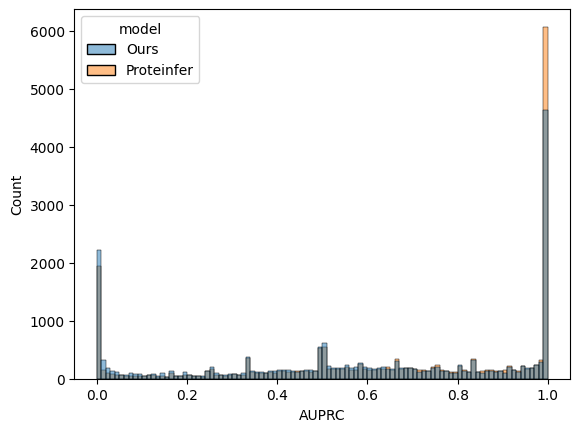

In [ ]:
sns.histplot(data = res.reset_index(),x='AUPRC',hue='model',bins=100)

In [ ]:
res_pivot = res.pivot(columns=['model'],values=['AUPRC','Frequency'])
res_pivot.columns = [i[0]+'_'+i[1] for i in res_pivot.columns]
ours_better = res_pivot[res_pivot['AUPRC_Ours']>res_pivot['AUPRC_Proteinfer']].sort_values(by='Frequency_Ours',ascending=False)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()


23.943886497688506
8.06631595727722
8.305435995536426
9.995217599234817
10.004782400765183
9.749721026622032
9.947393591582975
10.007970667941974
9.979276263350869


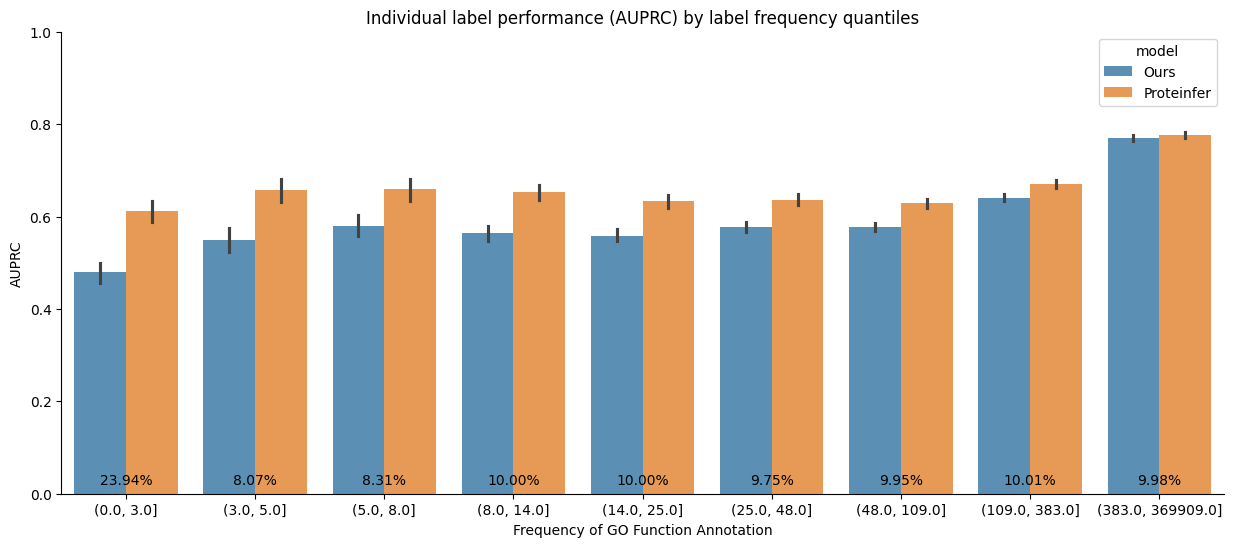

In [ ]:
metric = 'AUPRC'
quantiles = 10 #May not find desired number and could be less.

#Bin frequencies
freq_bins, freq_bin_edges = pd.qcut(go_term_distribution,q=quantiles,duplicates='drop',precision=0,retbins=True, labels=None)

res['Frequency Bin']=res.index.map(freq_bins)
res.dropna(subset=["AUPRC"],inplace=True)
freq_bins_pct = freq_bins.value_counts()*100/len(go_term_distribution)
fig, ax = plt.subplots(figsize=(15,6))

# Annotate bars with the percentage of observations
for index, value in enumerate(freq_bins_pct.sort_index().values):
    print(value)
    ax.text(index, ax.get_ylim()[1]*0.01 + max(res[metric]) * 0.01, f"{value:.2f}%", ha='center')


sns.barplot(data = res.reset_index(drop=True),
            x='Frequency Bin',
            y=metric,
            alpha=0.8,
            errorbar=('ci', 95),
            hue='model')
ax.set(title=f'Individual label performance ({metric}) by label frequency quantiles',
       xlabel='Frequency of GO Function Annotation',
       ylabel=metric)
sns.despine()
plt.ylim(0,1)
plt.show()

In [ ]:
res_ours = res.loc[res['model']=='Ours']
res_pinf = res.loc[res['model']=='Proteinfer']

res_ours[res_ours['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.996428,Ours,369909.0,"(383.0, 369909.0]"
GO:0008150,0.989658,Ours,346677.0,"(383.0, 369909.0]"
GO:0005575,0.993896,Ours,321980.0,"(383.0, 369909.0]"
GO:0009987,0.984949,Ours,295442.0,"(383.0, 369909.0]"
GO:0044464,0.988314,Ours,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:0033400,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0120012,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0035589,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0050643,1.000000,Ours,NaN,NaN


In [ ]:
res_ours[res_ours['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.966465
Frequency    8255.058458
dtype: float64

In [ ]:
res_pinf[res_pinf['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.994481,Proteinfer,369909.0,"(383.0, 369909.0]"
GO:0008150,0.983664,Proteinfer,346677.0,"(383.0, 369909.0]"
GO:0005575,0.992867,Proteinfer,321980.0,"(383.0, 369909.0]"
GO:0009987,0.980420,Proteinfer,295442.0,"(383.0, 369909.0]"
GO:0044464,0.986555,Proteinfer,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:1904025,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0033841,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0090425,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0021837,1.000000,Proteinfer,1.0,"(0.0, 3.0]"


In [ ]:
res_pinf[res_pinf['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.988498
Frequency    1798.803335
dtype: float64

In [ ]:
res_pinf.loc[res_ours[res_ours['AUPRC']>=0.8].index]['AUPRC'].mean()

0.9623318579385053

Explore worst errors

In [ ]:
ours_val_fl_losses.shape

torch.Size([44300, 32102])

In [ ]:
ours_val_fl_df = pd.DataFrame(ours_val_fl_losses.numpy(),index=val_labels.index,columns=val_labels.columns)

In [ ]:
ours_val_fl_df

,GO:0000001,GO:0000002,GO:0000003,GO:0000006,GO:0000007,GO:0000009,GO:0000010,GO:0000011,GO:0000012,GO:0000014,...,GO:2001305,GO:2001306,GO:2001307,GO:2001308,GO:2001310,GO:2001311,GO:2001313,GO:2001315,GO:2001316,GO:2001317
Q6AF49,0.000000e+00,0.000000e+00,1.154452e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.228224e-09,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
Q9MS73,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A5FYS5,0.000000e+00,7.903817e-17,1.694066e-21,0.000000e+00,0.000000e+00,5.867545e-09,1.004901e-16,0.000000e+00,2.509816e-15,1.614107e-14,...,1.459441e-14,0.0,1.873496e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A5G348,2.927344e-18,1.300163e-08,3.881737e-10,6.323040e-16,1.598267e-05,2.395686e-13,0.000000e+00,8.924287e-15,6.674357e-09,1.039228e-11,...,1.543713e-16,0.0,1.355253e-20,1.972197e-12,3.237299e-13,0.000000e+00,5.810643e-19,3.659181e-19,1.694066e-21,0.0
Q5WFY4,0.000000e+00,1.731027e-14,8.238461e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.615977e-11,5.326664e-16,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q589A6,2.305630e-11,1.028675e-07,8.575885e-07,0.000000e+00,1.694066e-21,1.904007e-14,0.000000e+00,5.551105e-17,3.641385e-05,1.457440e-09,...,1.745387e-15,0.0,3.721860e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A9M9U0,0.000000e+00,1.355253e-20,5.326664e-16,0.000000e+00,0.000000e+00,0.000000e+00,3.659181e-19,0.000000e+00,0.000000e+00,0.000000e+00,...,2.220794e-13,0.0,1.161958e-17,4.573977e-20,1.694066e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
A4IQ63,0.000000e+00,0.000000e+00,3.116989e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.305314e-16,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
Q0SYD4,0.000000e+00,1.694066e-21,2.818410e-13,0.000000e+00,0.000000e+00,1.694066e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.254800e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
loss_by_label = pd.concat([ours_val_fl_df.agg(['mean','median'],axis=0).T,
    label_descriptions,
    res[res['model']=='Ours'].drop(['model'],axis=1)],axis=1).dropna()

loss_by_sequence = ours_val_fl_df.agg(['mean','median'],axis=1).dropna()

In [ ]:
for idx,row in loss_by_label.sort_values(by='mean',ascending=False).iloc[:10].iterrows():
    print(idx,row['label'])
    print('\n-----------')

GO:0043226 organized structure of distinctive morphology and function. includes the nucleus, mitochondria, plastids, vacuoles, vesicles, ribosomes and the cytoskeleton, and prokaryotic structures such as anammoxosomes and pirellulosomes. excludes the plasma membrane.

-----------
GO:0044444 any constituent part of the cytoplasm, all of the contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures.

-----------
GO:0043229 organized structure of distinctive morphology and function, occurring within the cell. includes the nucleus, mitochondria, plastids, vacuoles, vesicles, ribosomes and the cytoskeleton. excludes the plasma membrane.

-----------
GO:0043227 organized structure of distinctive morphology and function, bounded by a single or double lipid bilayer membrane. includes the nucleus, mitochondria, plastids, vacuoles, and vesicles. excludes the plasma membrane.

-----------
GO:0009987 any process that is carried out at the cellular lev

In [ ]:
loss_by_sequence.sort_values(by='mean')

,mean,median
Q5FUG0,1.502230e-11,0.000000e+00
Q602S0,7.422003e-11,0.000000e+00
Q1MND4,7.841468e-11,0.000000e+00
Q5FUM8,1.432559e-10,0.000000e+00
Q2L066,1.630592e-10,0.000000e+00
...,...,...
B2RWS6,6.181519e-02,0.000000e+00
Q9NFU0,6.340533e-02,0.000000e+00
P84025,8.545986e-02,0.000000e+00
Q5NTH0,1.013311e-01,1.355253e-20


In [ ]:
(loss_by_sequence['mean']>0.001).sum()

7189

In [ ]:
loss_by_sequence.shape

(44300, 2)

<Axes: >

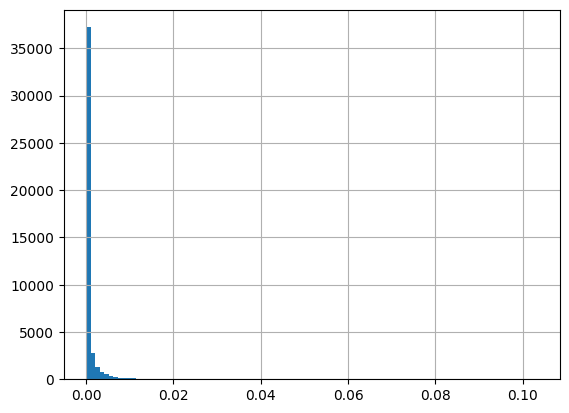

In [ ]:
loss_by_sequence['mean'].hist(bins=100)

In [ ]:
loss_by_label['mean'].describe()

count    2.143000e+04
mean     1.219555e-03
std      4.666291e-03
min      7.248066e-13
25%      4.160796e-05
50%      2.115680e-04
75%      6.974551e-04
max      9.733576e-02
Name: mean, dtype: float64

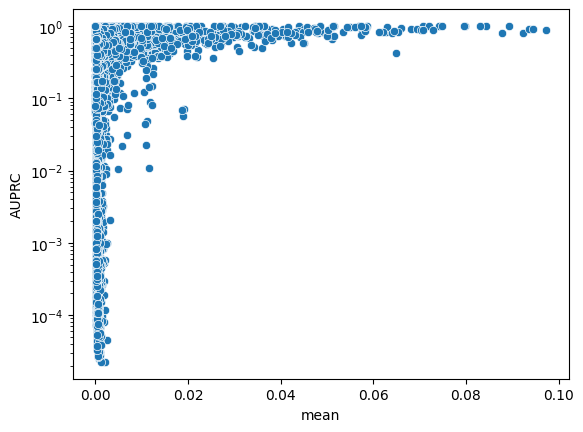

In [ ]:
sns.scatterplot(data=loss_by_label,x='mean',y='AUPRC')
plt.yscale('log')

In [ ]:
loss_by_label.sort_values(by='AUPRC',ascending=True)

,mean,median,label,AUPRC,Frequency,Frequency Bin
GO:0018894,2.107442e-03,0.000000e+00,the chemical reactions and pathways involving ...,0.000023,18.0,"(14.0, 25.0]"
GO:0033195,1.297307e-03,1.694066e-21,any process that results in a change in state ...,0.000023,1.0,"(0.0, 3.0]"
GO:0021794,8.668663e-04,0.000000e+00,the process in which the thalamus changes over...,0.000025,32.0,"(25.0, 48.0]"
GO:0035805,6.822970e-04,1.694066e-21,a specialized extracellular matrix that surrou...,0.000027,4.0,"(3.0, 5.0]"
GO:0051882,5.146728e-04,6.087953e-17,the process in which the potential difference ...,0.000027,8.0,"(5.0, 8.0]"
...,...,...,...,...,...,...
GO:0098951,2.532424e-07,0.000000e+00,the component of the postsynaptic recycling en...,1.000000,5.0,"(3.0, 5.0]"
GO:0098949,1.681292e-07,0.000000e+00,the component of the postsynaptic endosome mem...,1.000000,5.0,"(3.0, 5.0]"
GO:0009045,7.652585e-06,0.000000e+00,catalysis of the reaction: d-xylose = d-xylulose.,1.000000,157.0,"(109.0, 383.0]"
GO:0061673,8.529397e-06,0.000000e+00,any of the mitotic spindle microtubules that r...,1.000000,19.0,"(14.0, 25.0]"


In [ ]:
loss_by_label.groupby('Frequency Bin')[['mean','median','AUPRC']].mean()

/tmp/ipykernel_2854353/1542846960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_by_label.groupby('Frequency Bin')[['mean','median','AUPRC']].mean()


,mean,median,AUPRC
Frequency Bin,,,
"(0.0, 3.0]",0.000147,2.385207e-16,0.478933
"(3.0, 5.0]",0.000132,1.677594e-16,0.548990
"(5.0, 8.0]",0.000120,1.380560e-14,0.578740
"(8.0, 14.0]",0.000142,9.842679e-15,0.564338
"(14.0, 25.0]",0.000180,1.431132e-13,0.558794
"(25.0, 48.0]",0.000246,1.742332e-11,0.576597
"(48.0, 109.0]",0.000444,1.105453e-11,0.577686
"(109.0, 383.0]",0.000913,1.018724e-11,0.640943
"(383.0, 369909.0]",0.006323,2.650965e-07,0.769790


In [ ]:
loss_by_label[['Frequency','AUPRC']].corr()

,Frequency,AUPRC
Frequency,1.000000,0.090163
AUPRC,0.090163,1.000000


In [ ]:
ours_val_fl_df_melt = ours_val_fl_df.melt(ignore_index=False,var_name='label',value_name='mean_loss')

In [ ]:
ours_val_fl_df_melt = ours_val_fl_df_melt.sort_values(by='mean_loss',ascending=False)

In [ ]:
ours_val_fl_df_melt.head(100000).index.value_counts()

P84025    288
Q9D906    255
P0DJG1    253
P62979    250
P42160    235
         ... 
B0BNG2      1
Q86WD7      1
P14480      1
Q80XF7      1
Q9PLP9      1
Name: count, Length: 7766, dtype: int64

In [ ]:
ours_val_fl_df.loc['P0DJG1'].sort_values()

GO:0000001     0.000000
GO:0060366     0.000000
GO:0060365     0.000000
GO:0060364     0.000000
GO:0060363     0.000000
                ...    
GO:0010811    11.202832
GO:0010720    11.820147
GO:1900024    13.609342
GO:0010770    14.351546
GO:1900026    15.171867
Name: P0DJG1, Length: 32102, dtype: float32

In [ ]:
val_labels.loc['P0DJG1'].sort_values().sum()

33

In [ ]:
train_unrepresented_labels = set(val_labels.columns) - set(go_term_distribution.index)

In [ ]:
train_unrepresented_labels

In [ ]:
loss_by_label.shape

(21430, 6)

In [ ]:
loss_by_label.loc[list(train_unrepresented_labels)]

KeyError: "None of [Index(['GO:0052231', 'GO:0046595', 'GO:0052191', 'GO:1903040', 'GO:0018530',\n       'GO:1905306', 'GO:0042848', 'GO:0051470', 'GO:0097627', 'GO:1990596',\n       ...\n       'GO:0031774', 'GO:0072552', 'GO:0030772', 'GO:0044619', 'GO:2001194',\n       'GO:0052371', 'GO:1900000', 'GO:0033820', 'GO:0060858', 'GO:0080185'],\n      dtype='object', length=737)] are in the [index]"

Other stuff

In [ ]:


ground_truth = torch.tensor(val_labels.values)
preds = torch.tensor(val_probabilities.values)
sp = AveragePrecision(task="multilabel",num_labels=val_labels.shape[-1],average='macro').to('cuda')(preds,ground_truth).item()

ground_truth = torch.tensor(val_labels[items].values)
preds = torch.tensor(val_probabilities[items].values)
APMicro = AveragePrecision(task="multilabel",num_labels=len(items),average='micro').to('cuda')(preds,ground_truth).item()

/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
val_logits_t = torch.tensor(val_logits.values)
val_labels_t = torch.tensor(val_labels.values).float()
val_probabilities_t = torch.sigmoid(val_logits_t)

val_probabilities = pd.DataFrame(val_probabilities_t.numpy(),columns=val_logits.columns,index=val_logits.index)

In [ ]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated

threshold = 0.5
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)

100%|██████████| 2179/2179 [00:10<00:00, 204.37it/s]


In [ ]:
res['AUPRC'].mean()

0.2610842891522143

In [ ]:

ground_truth = torch.tensor(val_labels.values,device='cuda')
preds = torch.tensor(val_probabilities.values,device='cuda')
APMicro = AveragePrecision(task="multilabel",
                           num_labels=preds.shape[1],
                           average='micro',
                           thresholds=50).to('cuda')(preds,ground_truth).item()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.53 GiB (GPU 0; 79.10 GiB total capacity; 73.60 GiB already allocated; 4.21 GiB free; 73.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
APMicro

0.1679229736328125

In [ ]:
eval_metrics = EvalMetrics(device='cuda')

In [ ]:
m=eval_metrics.get_metric_collection_with_regex(pattern="f1_m.*", threshold=0.5,
                                                                num_labels=preds.shape[1]
                                                                )
m(preds,ground_truth)

{'f1_macro': tensor(0.2005, device='cuda:0'),
 'f1_micro': tensor(0.6187, device='cuda:0')}

In [ ]:
th = 0.5

tp = ((preds>th)*1)*ground_truth
fp = ((preds>th)*1)*(1-ground_truth)
fn = (1-(preds>th)*1)*(ground_truth)
tn = (1-(preds>th)*1)*(1-ground_truth)

In [ ]:
recall_micro = tp.sum()/(tp.sum()+fn.sum())
precision_micro = tp.sum()/(tp.sum()+fp.sum())
f1_micro = 2*recall_micro*precision_micro/(recall_micro+precision_micro)


recall_macro = tp.sum(axis=0)/(tp.sum(axis=0)+fn.sum(axis=0))
precision_macro = tp.sum(axis=0)/(tp.sum(axis=0)+fp.sum(axis=0))
f1_macro = 2*recall_macro*precision_macro/(recall_macro+precision_macro)

f1_micro,f1_macro

(tensor(0.6187, device='cuda:0'),
 tensor([0.0541,    nan, 0.4000,  ...,    nan, 0.5000,    nan], device='cuda:0'))